In [126]:
import numpy as np
import cv2
import os
from random import shuffle
from tqdm import tqdm

# Parametros de datos y CNN
imgSize = 50
learningRate = 1e-3
modelName =  'perros-gatos-{}-{}.model'.format(learningRate, '6conv-basic')


In [101]:
'''
Clasificacion:
Gatitos: [1,0]
Perritos: [0,1]
'''

def labelImg(imgP):
    strLabel = str(imgP).split('.')[0]
    if strLabel == 'cat':
        return [1,0]
    elif strLabel == 'dog':
        return [0,1]

In [112]:
def genTrainData():
    
    # Matriz que contendra todos los datos de training
    tData = []
    
    for img in tqdm(os.listdir('CNN_Data/training_set')):
        path = os.path.join('CNN_Data/training_set', img)
        
        # Etiquetado
        label = labelImg(img) 
        
        # Conv. a escala de grises
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        try:
            # Ajuste de tamano
            img = cv2.resize(img,(imgSize,imgSize))
            # Agregamos a la matriz array de escala de grises y etiqueta
            tData.append([np.array(img), np.array(label)])
        except:
            pass
        
    shuffle(tData)
    print('Imagenes catalogadas: ', len(tData))
    
    # Guardamos para uso futuro
    np.save('trainData.npy', tData)
    
    return tData

In [113]:
# Para llamarlos:
trainData = genTrainData()
# trainData = np.Load('trainData.npy')
#print(len(trainData))

100%|██████████| 4677/4677 [00:03<00:00, 1209.61it/s]


Imagenes catalogadas:  4676


In [127]:
def genTestData():
    
    # Matriz que contendra todos los datos de training
    tData = []
    
    for img in tqdm(os.listdir('CNN_Data/test_set')):
        
        try:
            path = os.path.join('CNN_Data/test_set', img)
            # Ajuste de tamano y conv. a escala de grises
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (imgSize,imgSize))
            # Etiquetado
            label = labelImg(img) 
            # Agregamos a la matriz array de escala de grises y etiqueta
            tData.append([np.array(img), np.array(label)])
            
        except Exception as e:
            pass
            #print(str(e))
        
    shuffle(tData)
    
    # Guardamos para uso futuro
    np.save('testData.npy', tData)
    
    return tData

In [142]:
def genIndividualTest():
    
    # Matriz que contendra todos los datos de training
    tData = []
    
    for img in tqdm(os.listdir('CNN_Data/Luna')):
        
        try:
            path = os.path.join('CNN_Data/Luna', img)
            # Ajuste de tamano y conv. a escala de grises
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (imgSize,imgSize))
            # Agregamos a la matriz array de escala de grises y etiqueta
            tData.append([np.array(img)])
            
        except Exception as e:
            pass
            #print(str(e))
        
    shuffle(tData)
    
    # Guardamos para uso futuro
    np.save('lunaData.npy', tData)
    
    return tData

In [121]:
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()

convnet = input_data(shape=[None, imgSize, imgSize, 1], name='input')

# Capas de COVNET = 6
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# Grafos fuertemente conectados
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

# 2 outputs: Perro o gato
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=learningRate, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [75]:
# Cargar modelo si ya generamos uno
if os.path.exists('{}.meta'.format(modelName)):
    model.load(modelName)
    print("Modelo cargado.")

In [116]:
# Separamos trainData para internal testing (test son ultimos 500)
train = trainData[:-500]
test = trainData[-500:]

In [143]:
X = np.array([i[0] for i in train]).reshape(-1, imgSize, imgSize, 1)
Y = [i[1] for i in train]

testX = np.array([i[0] for i in test]).reshape(-1, imgSize, imgSize, 1)
testY = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': testX}, {'targets': testY}), 
    snapshot_step=500, show_metric=True, run_id='modelName')

Training Step: 1517  | total loss: 0.14982 | time: 9.362s
| Adam | epoch: 023 | loss: 0.14982 - acc: 0.9439 -- iter: 4160/4176
Training Step: 1518  | total loss: 0.15284 | time: 10.481s
| Adam | epoch: 023 | loss: 0.15284 - acc: 0.9401 | val_loss: 0.72994 - val_acc: 0.7740 -- iter: 4176/4176
--


In [124]:
# Guardamos el modelo para uso futuro
model.save(modelName)

INFO:tensorflow:/Users/emamex98/Documents/PF-Algo/perros-gatos-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 5/5 [00:00<00:00, 24.85it/s]


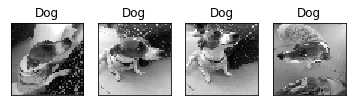

In [151]:
import matplotlib.pyplot as plt

#testData = genTestData()
testData = genIndividualTest()
# Si ya lo tenemos
#testData = np.load('testData.npy')

fig = plt.figure()

'''
for num, data in enumerate(testData[:12]):
    
    testData = data[0]
    #testLabel = data[1]
    
    y = fig.add_subplot(3,4, num+1)
    orig = testData
    data = testData.reshape(imgSize, imgSize,1)
    
    modelOut = model.predict([data])[0]
    
    if np.argmax(modelOut) == 1:
        testLabel = 'Dog'
    else:
        testLabel = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(testLabel)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

'''
# Individual test
for num, data in enumerate(testData):
    
    testData = data[0]
    
    y = fig.add_subplot(1,4, num+1)
    orig = testData
    data = testData.reshape(imgSize, imgSize,1)
    
    modelOut = model.predict([data])[0]
    
    if np.argmax(modelOut) == 1:
        testLabel = 'Dog'
    else:
        testLabel = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(testLabel)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()
